## Testing the Reading of Data

This is a testbed Jupyter notebook to read in the data we need for the COVID Data Vizualization Project.

- Possible data sources that we are considering:
    - https://data.humdata.org/dataset/novel-coronavirus-2019-ncov-cases 
    - https://covid19api.com   (This is just a JSON representation of John Hopkins Data above)
    - https://www.google.com/covid19/mobility/ 
    - https://www.apple.com/covid19/mobility

In [150]:
%matplotlib inline

import numpy as np
import git
import pandas as pd
from datetime import date, timedelta
import matplotlib.pyplot as plt
import requests

##  Novel Coronavirus (COVID-19) Cases Data
    - https://data.humdata.org/dataset/novel-coronavirus-2019-ncov-cases

This dataset is part of COVID-19 Pandemic Novel Corona Virus (COVID-19) epidemiological data since 22 January 2020. The data is compiled by the Johns Hopkins University Center for Systems Science and Engineering (JHU CCSE) from various sources including the World Health Organization (WHO), DXY.cn, BNO News, National Health Commission of the People’s Republic of China (NHC), China CDC (CCDC), Hong Kong Department of Health, Macau Government, Taiwan CDC, US CDC, Government of Canada, Australia Government Department of Health, European Centre for Disease Prevention and Control (ECDC), Ministry of Health Singapore (MOH), and others. JHU CCSE maintains the data on the 2019 Novel Coronavirus COVID-19 (2019-nCoV) Data Repository on Github (https://github.com/CSSEGISandData/COVID-19).

In [106]:
# To make sure we have current data, I went to the directory containing this Jupyter script and issued a "git clone https://github.com/CSSEGISandData/COVID-19.git" to
# pull the complete dataset from GitHub.  That created a COVID-19 directory, which I renamed "JH_Data". Now it should be a short "git pull" command to keep the data up to date.

JHdata_dir = "JH_Data/"
g = git.cmd.Git(JHdata_dir)
status = g.pull()  # We should check status to see everything is good eventually, for now, I am using this to hide the status message from GitPython module

# Another choice would be to autogenerate the CSV URLs and retrieve them individually.

In [107]:
# csse_covid_19_data/csse_covid_19_daily_reports contains a daily CSV with a list of confirmed/deaths/recovered for each admin unit (in the US, that's county) for each day.
# csse_covid_19_data/csse_covid_19_daily_reports_us contains a daily CSV with list of confirmed/deaths/recovered totaled for each state (somewhat redundant, but avoids recomputation I suppose)

# Construct filename of yesterday's CSV datafile
yesterday = today - timedelta(days = 1) 
yesterday_csv = f"{yesterday.month:02d}-{yesterday.day:02d}-{yesterday.year:04d}.csv"

# Build daily data filenames
daily_world_csv = JHdata_dir+"csse_covid_19_data/csse_covid_19_daily_reports/"+yesterday_csv
daily_us_csv = JHdata_dir+"csse_covid_19_data/csse_covid_19_daily_reports_us/"+yesterday_csv

# Create pandas dataframes containing the daily data from the CSV files (contains number of confirmed/deaths/recovered on that date)
daily_world_df = pd.read_csv(daily_world_csv)   # County/Admin totals
daily_us_df = pd.read_csv(daily_us_csv)         # State totals

# csse_covid_19_data/csse_covid_19_time_series contains time-series (so the location, the COVID status, and the number, one column for each date) 
#                                                  time_series_covid19_confirmed_US.csv, time_series_covid19_deaths_US.csv listing county-level data in the US and 
#                                                  time_series_covid19_confirmed_global.csv, time_series_covid19_deaths_global.csv, and time_series_covid19_recovered_global.csv for the world.

# Create pandas dataframes containing time-series data (We could reconstruct this by looping through all the daily data, since this is missing number of recovered)
ts_us_dead_csv = JHdata_dir+"csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv"
ts_us_confirmed_csv = JHdata_dir+"csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv"
ts_us_dead_df = pd.read_csv(ts_us_dead_csv)            # Deaths in time series
ts_us_confirmed_df = pd.read_csv(ts_us_confirmed_csv)  # Confirmed in time series


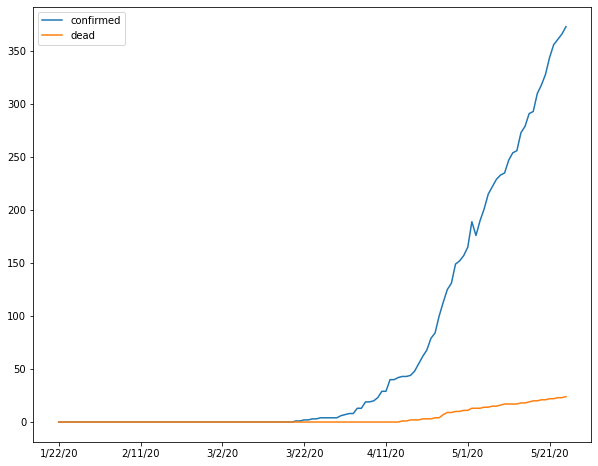

In [130]:
# We could transpose the dataframe to allow easier extraction of time series data on a per county level
tmp_df = ts_us_confirmed_df[ (ts_us_confirmed_df['Province_State'] == 'Minnesota') & (ts_us_confirmed_df['Admin2'] == 'Clay') ].T
tmp_df.rename(columns={ tmp_df.columns[0]: "confirmed" }, inplace = True)
confirmed_clay = tmp_df[tmp_df.index.str.match('[0-9]*/[0-9]*/[0-9]*')]  # Use pattern matching to find real dates and include

tmp_df = ts_us_dead_df[ (ts_us_confirmed_df['Province_State'] == 'Minnesota') & (ts_us_confirmed_df['Admin2'] == 'Clay') ].T
tmp_df.rename(columns={ tmp_df.columns[0]: "dead" }, inplace = True)
dead_clay = tmp_df[tmp_df.index.str.match('[0-9]*/[0-9]*/[0-9]*')] # Use pattern matching to find real dates and include

# Merge the confirmed ill and dead into one dataframe
merged_clay = confirmed_clay.merge(dead_clay, left_index=True, right_index=True)
merged_clay.plot(figsize=(10,8))

## Google Mobility Data

This data is described at https://www.google.com/covid19/mobility/ and can be downloaded in a single monolithic CSV file at https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv

In [134]:
# Google Mobility Data URL
goog_mobility_csv_url = "https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv"
goog_mobility_df=pd.read_csv(goog_mobility_csv_url, low_memory=False)

In [141]:
goog_mobility_clay = goog_mobility_df[ (goog_mobility_df['sub_region_1'] == 'Minnesota') & (goog_mobility_df['sub_region_2'] == 'Clay County')]

## Apple Mobility Data

This data is described at https://www.apple.com/covid19/mobility and can be downloaded in a single monolithic CSV file at https://covid19-static.cdn-apple.com/covid19-mobility-data/2008HotfixDev42/v3/en-us/applemobilitytrends-2020-05-24.csv (That URL is hidden in the mobility page link and appears to be updated regularly.  We may need to scrape the page to identify the link).


In [206]:
# Scraping the original Apple page was proving tricky as it had a bunch of javascript used to generate the URL, so I poked around and found a reference 
# at https://www.r-bloggers.com/get-apples-mobility-data/ to a JSON file at a stable URL that can be used to construct the appropriate URL for the current
# datafile.

aapl_mobility_json = "https://covid19-static.cdn-apple.com/covid19-mobility-data/current/v3/index.json"
aapl_server = "https://covid19-static.cdn-apple.com/"
result = requests.get(aapl_mobility_json)
# Proceed if we successfully pulled the page (HTTP status code 200)
if (result.status_code == 200):
    # Apple Mobility Data URL
    aapl_mobility_csv_url = aapl_server+json['basePath']+json['regions']['en-us']['csvPath']
    aapl_mobility_df=pd.read_csv(aapl_mobility_csv_url, low_memory=False)

In [207]:
# Just showing how I can get clay county data specifically
aapl_mobility_clay = aapl_mobility_df[(aapl_mobility_df['region'] == 'Clay County') & (aapl_mobility_df['sub-region'] == 'Minnesota')]

In [208]:
aapl_mobility_clay

,geo_type,region,transportation_type,alternative_name,sub-region,country,2020-01-13,2020-01-14,2020-01-15,2020-01-16,...,2020-05-16,2020-05-17,2020-05-18,2020-05-19,2020-05-20,2020-05-21,2020-05-22,2020-05-23,2020-05-24,2020-05-25
1909,county,Clay County,driving,NaN,Minnesota,United States,100.0,92.08,85.04,105.88,...,128.89,105.01,124.88,122.92,135.87,136.6,167.14,140.23,104.41,118.58
